In [105]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score
import seaborn as sb

# Project variables

In [82]:
m_name = "clickbait v1"
p_dir = os.path.join("../cb models", m_name)

In [83]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [84]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [85]:
create_dir(p_dir)
clear_dir(p_dir)

# Prepare dataset

In [86]:
df = pd.read_csv("../cb models/clickbait_data.csv")
df.shape

(32000, 2)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headline   32000 non-null  object
 1   clickbait  32000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.1+ KB


In [88]:
# There are a few headlines longer than 100 characters. These are to be removed because the youtube titles have a max length of 100 characters.
df = df.loc[df.headline.str.len() <= 100, :]
df.rename(columns={"headline": "title"}, inplace=True)
df.shape

(31865, 2)

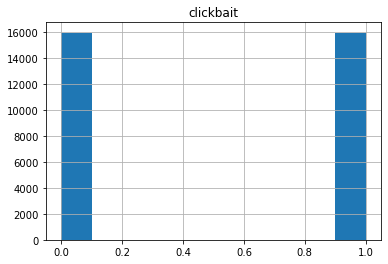

In [89]:
# How is the data distributed between clickbait and not clickbait?
df.hist()
plt.show()
# The data is about equally distributed between clickbaity and not

In [90]:
x = df.title
y = df.clickbait

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_val.shape[0], x_test.shape[0])

19119 6373 6373


# Build the model

In [91]:
def preprocessing(df: pd.DataFrame, remove_stopwords: bool=False) -> pd.DataFrame:
    field = "title"
    stw = set(stopwords.words("english"))
    
    def cleanse_row(row, field, stw, stopwords=False):
        # Remove HTML from text
        soup = BeautifulSoup(row[field])
        row[field] = soup.get_text()
        
        # Remove stopwords
        if stopwords:
            row[field] = " ".join([w for w in row[field].split() if w not in stw])
        
        return row
    
    df = df.apply(lambda row: cleanse_row(row, field, stw, remove_stopwords), axis=1)
    return df["title"]

In [92]:
# Download the stopwork corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [93]:
remove_stopwords = False

def preprocess_data(x: pd.DataFrame, remove_stopwords: bool=False) -> list():
    x_pp = preprocessing(x, remove_stopwords)
    x_pp = x_pp.tolist()
    return x_pp

In [94]:
x_train_pp = preprocess_data(x_train.to_frame())
x_val_pp = preprocess_data(x_val.to_frame())

In [95]:
pt_model = "distilbert-base-uncased"
tok = DistilBertTokenizer.from_pretrained(pt_model, do_lower=True, add_special_tokens=True, max_length=100, pad_to_max_length=True)

In [96]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=100, padding="max_length", return_attention_mask=True, 
                                       return_token_type_ids=True)
        input_ids.append(inputs["input_ids"])
        input_masks.append(inputs["attention_mask"])
        input_segments.append(inputs["token_type_ids"])
        
    return np.asarray(input_ids, dtype="int32"), np.asarray(input_masks, dtype="int32"), np.asarray(input_segments, dtype="int32")

In [110]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states=False
transformer_model = TFDistilBertModel.from_pretrained(pt_model, config=config)

in_ids = Input(shape=(100,), name="input_token", dtype="int32")
in_masks = Input(shape=(100,), name="masked_token", dtype="int32")

emb = transformer_model(in_ids, attention_mask=in_masks)[0]
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0))(emb)
x = GlobalMaxPool1D()(x)
x = Flatten()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, activation="softmax")(x)
model = Model(inputs=[in_ids, in_masks], outputs=x)

for layer in model.layers[:3]:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [111]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_5 (TFDisti TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 100, 100)     327600      tf_distil_bert_model_5[0][0

In [112]:
x_train_tok = tokenize(x_train_pp, tok)
x_val_tok = tokenize(x_val_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_val_b = lb.transform(y_val)

batch_size = 64
n_epochs = 20

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.0005), 
              metrics=["accuracy"])

metric = "val_accuracy"

es = EarlyStopping(monitor=metric, 
                   mode="max", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='max')

hist = model.fit(x_train_tok[:2], y_train_b, 
                 validation_data=(x_val_tok[:2], y_val_b), 
                 batch_size=batch_size, 
                 epochs=n_epochs, 
                 callbacks=[checkpoint, es])

Epoch 1/20
299/299 [==============================] - 96s 299ms/step - loss: 0.1190 - accuracy: 0.9573 - val_loss: 0.0625 - val_accuracy: 0.9779

Epoch 00001: val_accuracy improved from -inf to 0.97788, saving model to ../cb models/clickbait v1/clickbait v1
Epoch 2/20
299/299 [==============================] - 88s 295ms/step - loss: 0.0682 - accuracy: 0.9752 - val_loss: 0.0615 - val_accuracy: 0.9765

Epoch 00002: val_accuracy did not improve from 0.97788
Epoch 3/20
299/299 [==============================] - 88s 296ms/step - loss: 0.0552 - accuracy: 0.9805 - val_loss: 0.0507 - val_accuracy: 0.9827

Epoch 00003: val_accuracy improved from 0.97788 to 0.98274, saving model to ../cb models/clickbait v1/clickbait v1
Epoch 4/20
299/299 [==============================] - 88s 295ms/step - loss: 0.0467 - accuracy: 0.9834 - val_loss: 0.0480 - val_accuracy: 0.9845

Epoch 00004: val_accuracy improved from 0.98274 to 0.98447, saving model to ../cb models/clickbait v1/clickbait v1
Epoch 5/20
299/299 

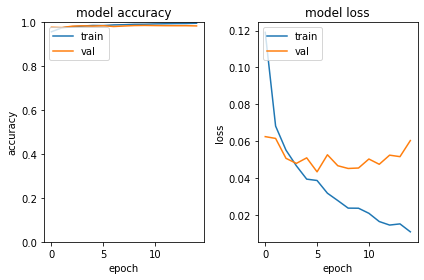

In [113]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
# axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Confusion matrix

In [114]:
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

## Validation data (in-sample)

In [115]:
x_val_tok = tokenize(x_val_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_val_b = lb.transform(y_val)

y_val_prob = model.predict(x_val_tok[:2], steps=y_val_b.shape[0])
y_pred = np.argmax(y_val_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

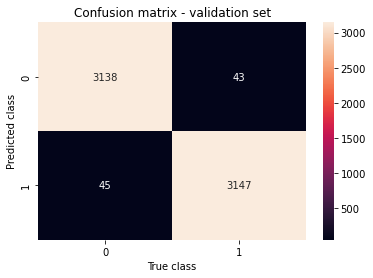

Accuracy: 0.99
Micro precision: 0.99
Micro recall: 0.99
Micro F1-score: 0.99
Macro precision: 0.99
Macro recall: 0.99
Macro F1-score: 0.99
Weighted precision: 0.99
Weighted recall: 0.99
Weighted F1-score: 0.99
              precision    recall  f1-score   support

    very low       0.99      0.99      0.99      3181
   very high       0.99      0.99      0.99      3192

    accuracy                           0.99      6373
   macro avg       0.99      0.99      0.99      6373
weighted avg       0.99      0.99      0.99      6373



In [116]:
cmtx = confusion_matrix(y_val, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - validation set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_val.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_val, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_val, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_val, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_val, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_val, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_val, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_val, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="weighted")))

print(classification_report(y_val, y_pred, target_names=cat_lbl))

## Test data (out-of-sample)

In [117]:
x_test_pp = preprocess_data(x_test.to_frame())
x_test_tok = tokenize(x_test_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b = lb.transform(y_test)

y_test_prob = model.predict(x_test_tok[:2], steps=y_test_b.shape[0])
y_pred = np.argmax(y_test_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

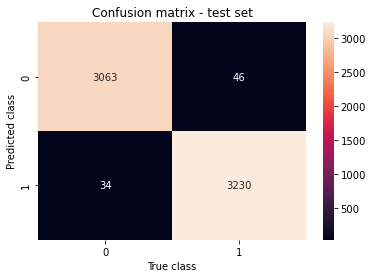

Accuracy: 0.99
Micro precision: 0.99
Micro recall: 0.99
Micro F1-score: 0.99
Macro precision: 0.99
Macro recall: 0.99
Macro F1-score: 0.99
Weighted precision: 0.99
Weighted recall: 0.99
Weighted F1-score: 0.99
              precision    recall  f1-score   support

    very low       0.99      0.99      0.99      3109
   very high       0.99      0.99      0.99      3264

    accuracy                           0.99      6373
   macro avg       0.99      0.99      0.99      6373
weighted avg       0.99      0.99      0.99      6373



In [118]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - test set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_test.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

print(classification_report(y_test, y_pred, target_names=cat_lbl))

# ROC curve

## Validation data (in-sample)

In [119]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_val_no = lb.fit_transform(y_val)
y_pred_no = y_val_prob[:, 1]
fpr, tpr, thr = roc_curve(y_val_no, y_pred_no)

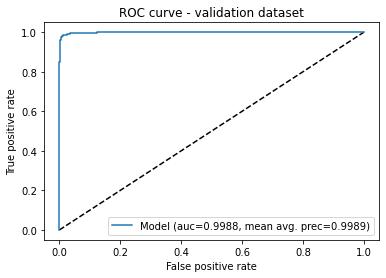

In [120]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_val_no, y_pred_no)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - validation dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_val.jpg"))
plt.show()

## Test data (out-of-sample)

In [121]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_test_no = lb.fit_transform(y_test)
y_pred_no = y_test_prob[:, 1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

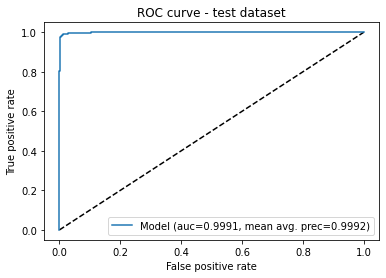

In [122]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_test.jpg"))
plt.show()

# Class probability histograms

## Without middle classes

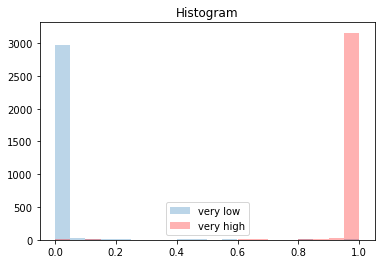

In [123]:
m0 = y_test_no[:, 0] == 0
c0 = y_test_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_test_prob[m1, 1]

plt.hist(c0, alpha=0.3, bins=20)
plt.hist(c1, color="red", alpha=0.3, bins=20)
plt.title("Histogram")
plt.legend(cat_lbl)
plt.savefig(os.path.join(p_dir, "histogram.jpg"))
plt.show()

# Sample titles

In [143]:
combo = pd.concat([x_test, y_test], axis=1)
combo.reset_index(drop=True, inplace=True)
combo = pd.concat([combo, pd.Series(y_pred, name="pred")], axis=1)
combo.rename(columns={"clickbait": "truth"}, inplace=True)
combo.shape

(6373, 3)

In [150]:
g = combo.groupby(["pred"], as_index=False).apply(lambda x: x.sample(5, random_state=682))
g[["title", "pred"]].head(10)
g.to_csv(os.path.join(p_dir, "titles.csv"), index=False)
g.head(10)

title  truth  pred
0 6257   Sierra Leone rebel convicts sent to Rwandan jail      0     0
  380   Unprecedented review to be held on Qantas afte...      0     0
  1592    English actress Elizabeth Taylor dies at age 79      0     0
  1752            US plan for broadband Internet released      0     0
  6066  South Africa reopens beaches after fatal shark...      0     0
1 4080  23 Sins Everyone Who Grew Up Drinking In Brita...      1     1
  3475  Let's Be Honest, GOP Candidate Lindsey Graham ...      1     1
  4770     17 Thanksgiving Turkey Mistakes Everyone Makes      1     1
  3979   We Know Your Favorite Ryan Based On One Question      1     1
  5714  10 Jack-O'-Lanterns That Would Terrify All Int...      1     1